In [1]:
%matplotlib nbagg
%load_ext line_profiler
%load_ext memory_profiler

import jungfrau_utils as ju
import numpy as np
import json
import os, math
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py

from alvra_tools import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

In [2]:
# Choose a pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals) 
# if you do not want to use the closest in time

# pedestal_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190727_2115.JF02T09V02.res.h5"
pedestal_file = None

In [4]:
# scan_name ="XES_jet_FeBpy_031"     #use this for a scan
#scan_name ="RuFoil_mono_1"     #use this for a single file
# pgroup ="p18938"

#######################################################################
"""
DIR_json = "/sf/alvra/data/{}/res/scan_info/".format(pgroup)
DIR = "/sf/alvra/data/{}/raw/scan_data/{}/".format(pgroup, scan_name) 
savedir = "/das/work/p18/{}/Export_PNG/".format(pgroup)

isscan = os.path.exists(DIR)
if isscan:
    DIR = DIR
else:
    DIR = "/sf/alvra/data/{}/raw/{}/".format(pgroup, scan_name)

print (DIR)
files_scan = glob.glob(DIR_json + scan_name + '.*')

try:
    scan_range = '.'+files_scan[-1].split('.')[-2]
    print ('Scan range runs: {}'.format(scan_range))
    !ls -lah -rt $DIR | grep JF*
    !hostname
except:
    print ('Single file, not a scan')
    !ls -lah -rt $DIR | grep JF*
    !hostname
"""
#######################################################################

scan_name ="XES_jet_FeBpy_001/"

DIR = "/sf/alvra/data/p18938/raw/" + scan_name

!ls -lah -t $DIR  | grep JF

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

-rw-r--r--.  1 root p18938  53G Feb  7 20:00 run_001730.JF02T09V02.h5
ra-c-067.psi.ch
There are 2 files in the folder /sf/alvra/data/p18938/raw/XES_jet_FeBpy_001/


/sf/alvra/data/p18938/raw/XES_jet_FeBpy_001/run_001730.JF02T09V02.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_000870.JF02T09V02.res.h5
jungfrau file: 20:00 07.02.2021
pedestal file: 12:20 07.02.2021
    mtime difference: 7:40:10.360263
Total number of images is 6000, load the first 6000
Shape of image: (514, 9318)
It took 238.68 seconds to process this file


<IPython.core.display.Javascript object>


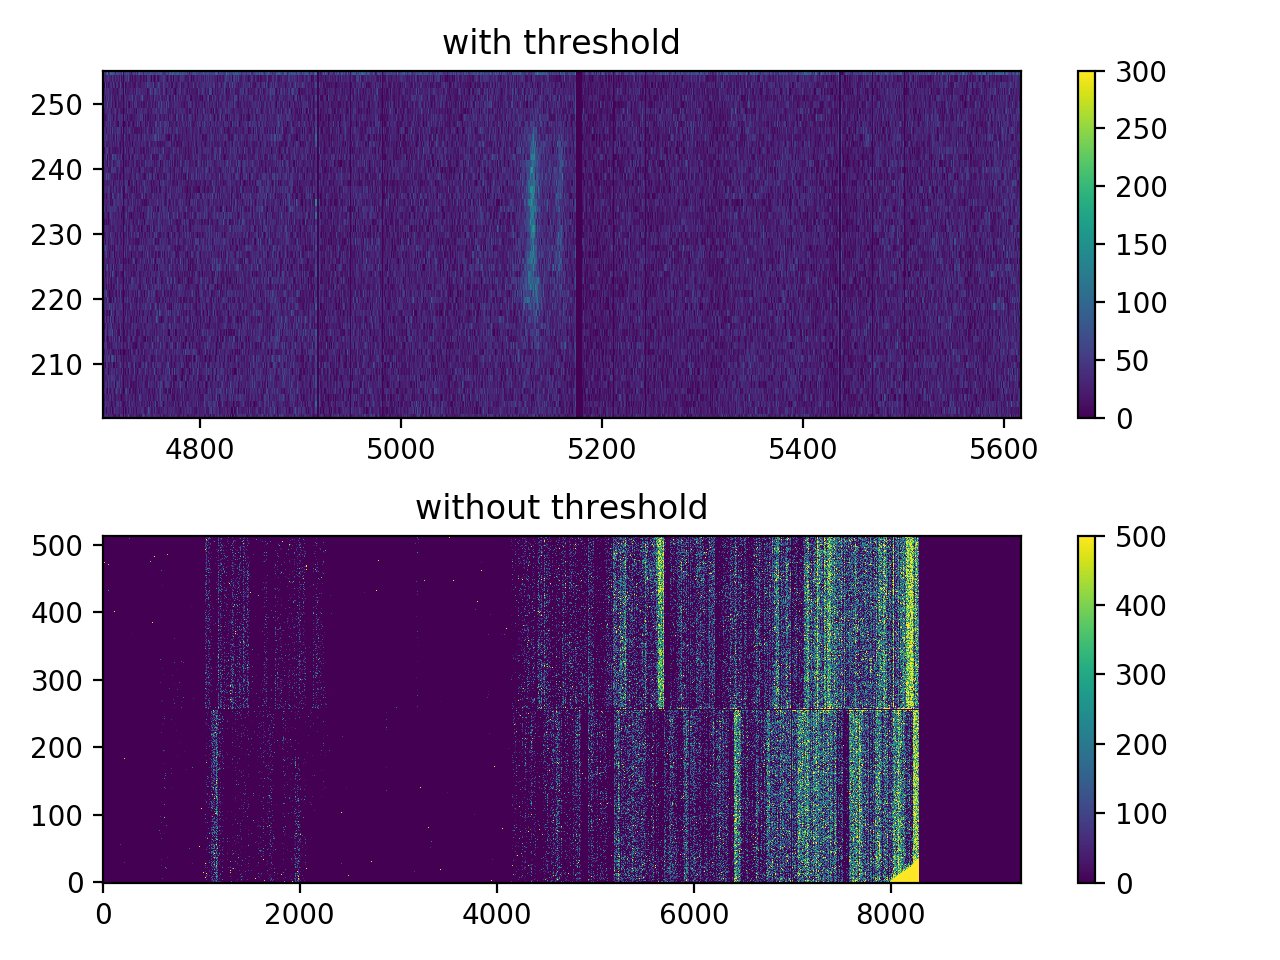

In [34]:
# First we load the first images of a file to check if everything is fine with the pedestal &  files (check high True or False)
# We can see also how the ROIs look like (will be useful later)

clock = Clock()

fileName = "run_001730.JF02T09V02.h5"

print(DIR + fileName)

nframes = 6000

total = 0
total_thr = 0

with ju.File(DIR + fileName, pedestal_file=pedestal_file) as juf:
    pulse_ids = juf["pulse_id"][:]
    print ('Total number of images is {}, load the first {}'.format(len(pulse_ids), nframes))

    for i in range(nframes):
        image = juf[i, :]
        image_thr = image.copy()
        image_thr[image < 5] = 0
        total_thr += image_thr
        total += image
        #total /= nframes
    
print ("Shape of image: {}".format(total_thr.shape))
print ("It took", clock.tick(), "seconds to process this file")

#roi = [[225, 325], [6950, 7075]]
#roi = [[225, 325], [7900, 8450]]
#roi = [[0, total_corr.shape[0]], [0, total_corr.shape[1]]]

plt.figure()
plt.subplots_adjust(wspace=0.5)
plt.subplot(211)
plt.imshow(total_thr, origin="lower", aspect='auto', vmin=0, vmax=300)
plt.title("with threshold")
plt.colorbar()
plt.subplot(212)
plt.imshow(total, origin="lower", aspect='auto', vmin=0, vmax=500)
plt.title("without threshold")
plt.colorbar()
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


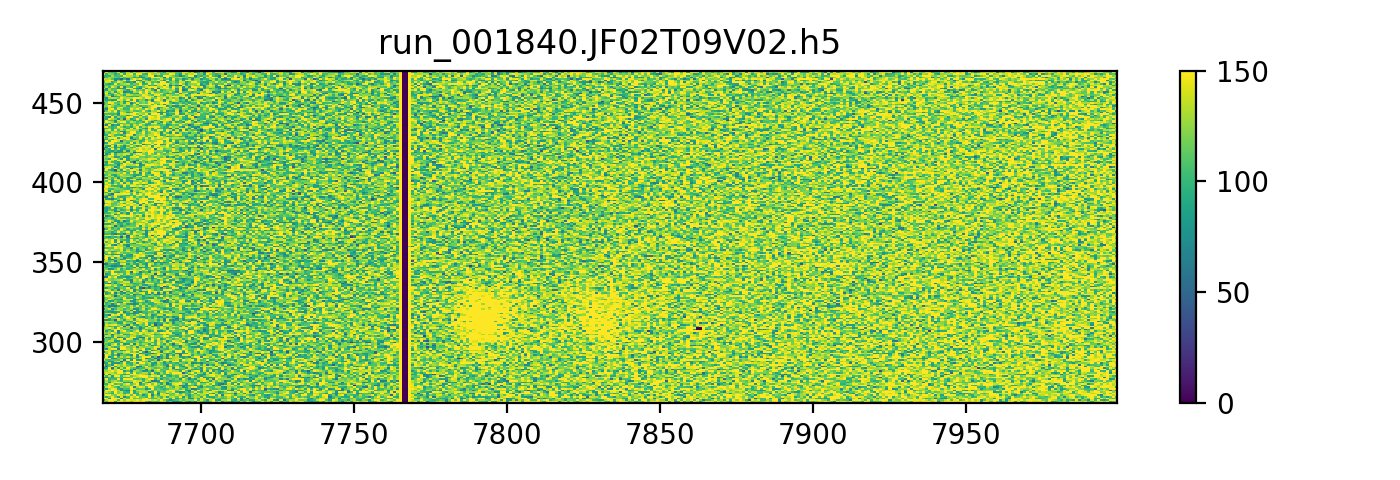

In [6]:
loadDir = '/sf/alvra/data/p18938/scratch/victoria/'
fname = 'FeBpy_total_thr_001.npy'
img = np.load(loadDir + fname)

plt.figure(figsize=(7,2.4))
# plt.imshow(total_thr, origin="lower", aspect='auto', vmin=0, vmax=150)
plt.imshow(img, origin="lower", aspect='auto', vmin=0, vmax=150)
plt.title(fileName)
plt.colorbar()
plt.tight_layout()
plt.show()

# np.save('/sf/alvra/data/p18938/scratch/victoria/FeBpy_total_thr_001.npy', total_thr)

<IPython.core.display.Javascript object>


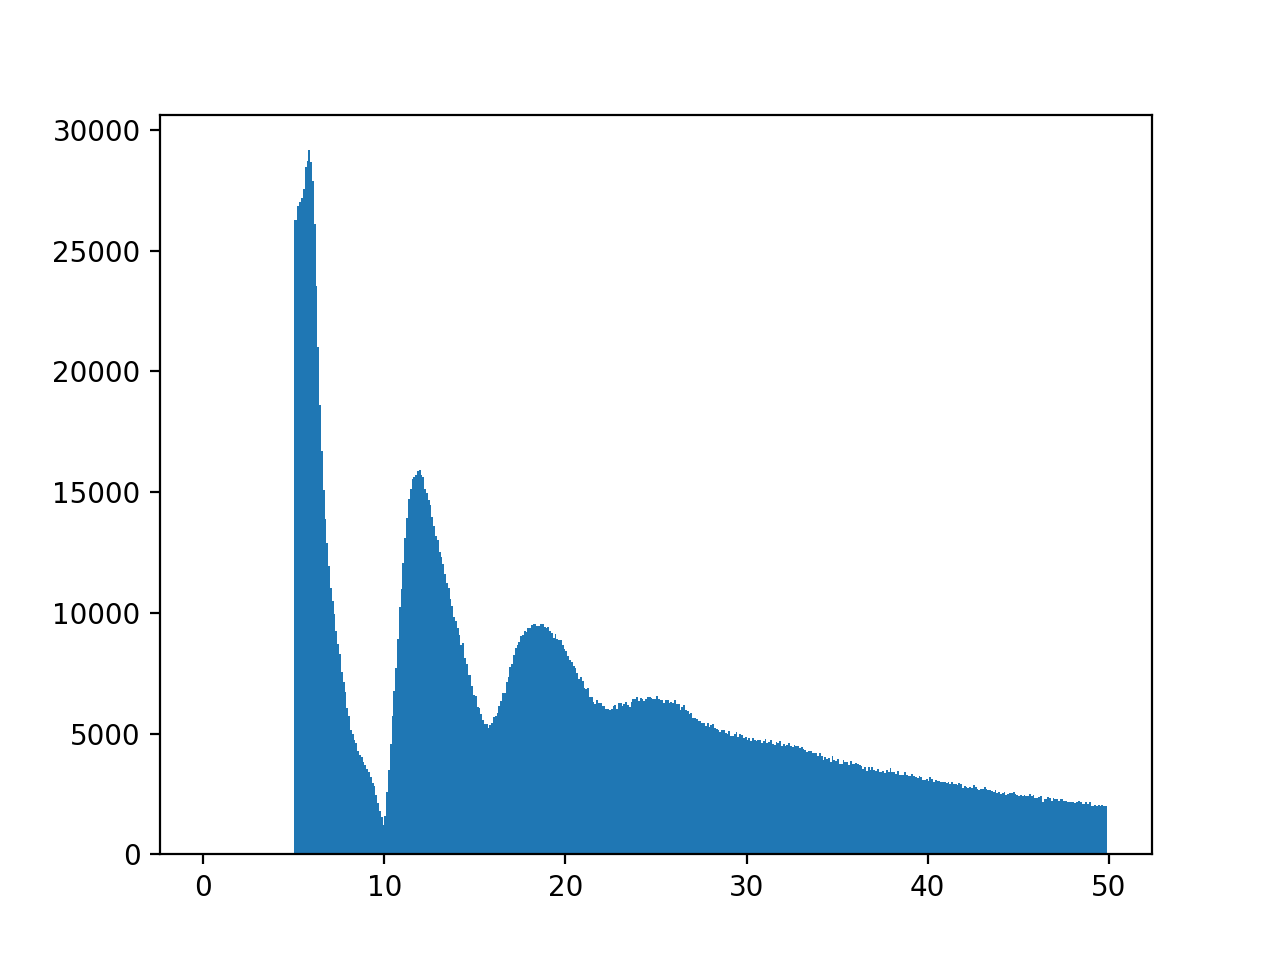

In [41]:
plt.figure()
plt.hist(total_thr.ravel(), bins=np.arange(0.1,50,0.1))
plt.show()

<IPython.core.display.Javascript object>


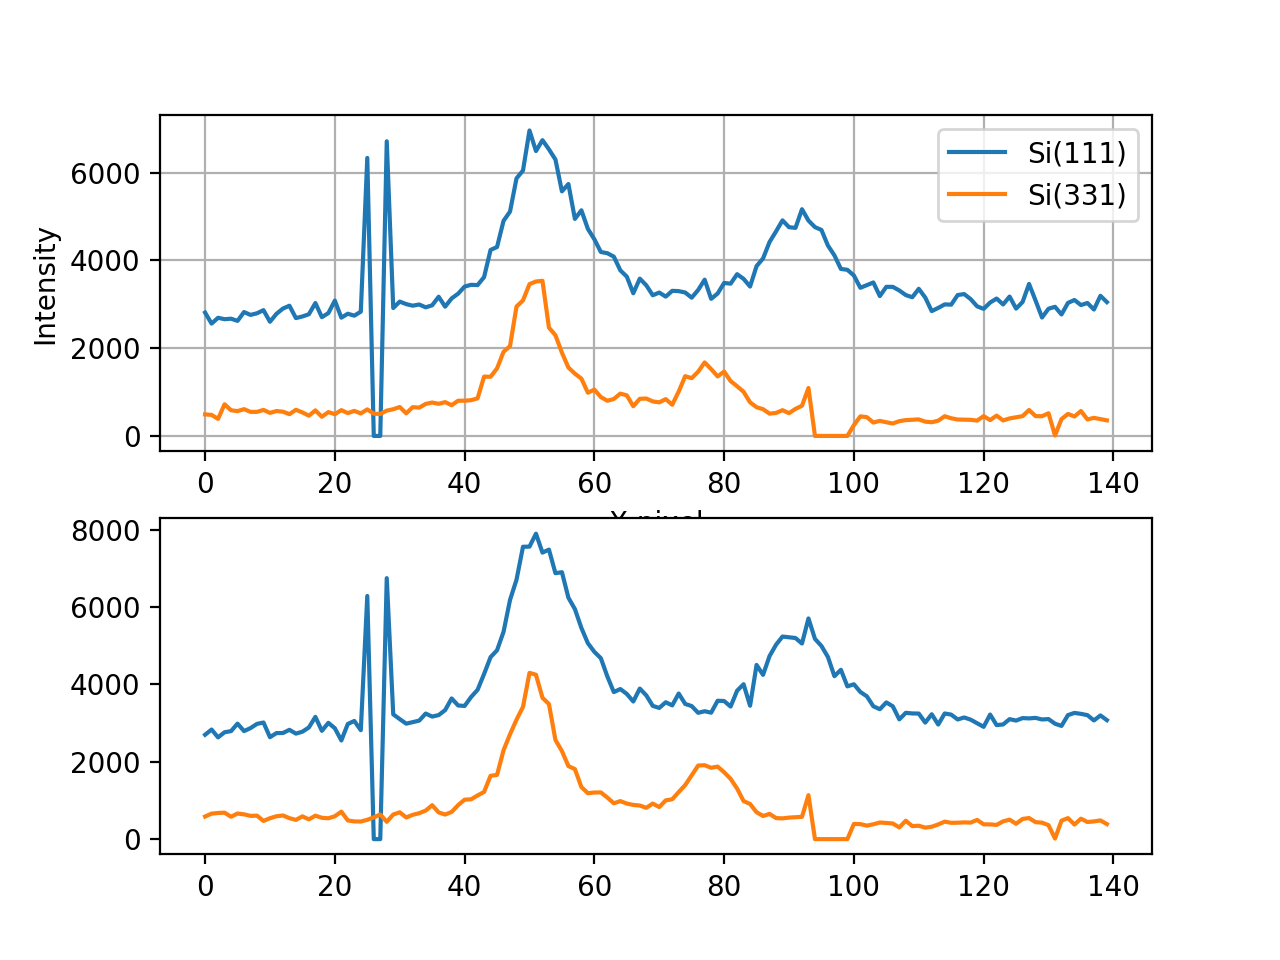

[('XES_jet_Fe', 946388.3125 , 182802.96875  )
 ('XES_jet_Fe', 562585.875  , 132960.0625   )
 ('XES_jet_Fe', 562109.1875 , 133535.421875 )
 ('XES_jet_Fe', 461723.875  ,  97264.5      )
 ('XES_jet_Fe', 475654.46875,  98837.109375 )
 ('XES_jet_Fe', 461540.40625,  92542.875    )
 ('XES_jet_Fe', 450512.375  ,  90381.28125  )
 ('XES_jet_Fe', 458312.90625,  90961.7890625)
 ('XES_jet_Fe', 449311.96875,  87757.546875 )
 ('XES_jet_Fe', 448891.5    ,  87596.2265625)
 ('XES_jet_Fe', 440026.5625 ,  84434.40625  )
 ('XES_jet_Fe', 440083.78125,  85323.9140625)
 ('XES_jet_Fe', 427925.28125,  81497.3203125)
 ('XES_jet_Fe', 425476.75   ,  79654.921875 )
 ('XES_jet_Fe', 421675.4375 ,  78188.609375 )
 ('XES_jet_Fe', 475087.4375 , 101398.203125 )
 ('XES_jet_Fe', 495891.5    , 108474.265625 )
 ('XES_jet_Fe', 501330.375  , 111130.703125 )
 ('XES_jet_Fe', 515406.03125, 117529.0859375)
 ('XES_jet_Fe', 527081.0625 , 117958.84375  )
 ('XES_jet_Fe', 529759.4375 , 123427.359375 )
 ('XES_jet_Fe', 551248.625  , 1287

In [16]:
# roi1 = (205, 255, 5080, 5220)
roi1 = (290, 340, 7740, 7880)
roi2 = (210, 250, 5080, 5220)

Ka_111 = np.sum(total_thr[roi1[0]:roi1[1], roi1[2]:roi1[3]], axis=0)
Ka_331 = np.sum(total_thr[roi2[0]:roi2[1], roi2[2]:roi2[3]], axis=0)

plt.figure()
plt.title("XES Fe(bpy)3 25 um jet")

plt.subplot(211)
plt.plot(Ka_111, label='Si(111)')
plt.plot(Ka_331, label='Si(331)')

plt.ylabel('Intensity')
plt.xlabel('X pixel')
plt.legend(loc="best")
plt.grid()

"""
np.save('/sf/alvra/data/p18938/scratch/victoria/FeBpy_Ka111_001.npy', Ka_111)
np.save('/sf/alvra/data/p18938/scratch/victoria/FeBpy_Ka331_001.npy', Ka_331)
"""
test1 = np.load('/sf/alvra/data/p18938/scratch/victoria/spectra_1d/FeBpy_Ka111_021.npy')
test2 = np.load('/sf/alvra/data/p18938/scratch/victoria/spectra_1d/FeBpy_Ka331_021.npy')
plt.subplot(212)
plt.plot(test1, label='Si(111)')
plt.plot(test2, label='Si(331)')
plt.show()

In [9]:
scan_names = ['XES_jet_FeBpy_{:03d}/'.format(i+1) for i in range(30)]
# print(scan_names)

roi1 = (290, 340, 7740, 7880)
roi2 = (210, 250, 5080, 5220)

roi3 = (385, 435, 7740, 7880)
roi4 = (145, 185, 5080, 5220)

nframes = 6000

total_roi_sum = []

for scan_name in scan_names:
    
    clock = Clock()

    DIR = "/sf/alvra/data/p18938/raw/" + scan_name

    # !ls -lah -t $DIR  | grep JF

    # !hostname

    fileName = max(os.listdir(DIR))

    print(DIR + fileName)

    total = 0
    total_thr = 0

    with ju.File(DIR + fileName, pedestal_file=pedestal_file) as juf:
        pulse_ids = juf["pulse_id"][:]
        print ('Total number of images is {}, load the first {}'.format(len(pulse_ids), nframes))

        for i in range(nframes):
            image = juf[i, :]
            image_thr = image.copy()
            image_thr[image < 5] = 0
            total_thr += image_thr
            total += image
            #total /= nframes
    
    print ("Shape of image: {}".format(total_thr.shape))
    print ("It took", clock.tick(), "seconds to process this file")
    print ('')
    
    np.save('/sf/alvra/data/p18938/scratch/victoria/FeBpy_total_thr_'+
            scan_name[-4:-1]+'.npy', total_thr)

    Ka_111 = np.sum(total_thr[roi1[0]:roi1[1], roi1[2]:roi1[3]], axis=0)
    Ka_331 = np.sum(total_thr[roi2[0]:roi2[1], roi2[2]:roi2[3]], axis=0)
    
    Ka_111_background = np.sum(total_thr[roi3[0]:roi3[1], roi3[2]:roi3[3]], axis=0)
    Ka_331_background = np.sum(total_thr[roi4[0]:roi4[1], roi4[2]:roi4[3]], axis=0)
    
    total_roi_sum.append((scan_name[:-1], np.sum(Ka_111), np.sum(Ka_331)))

    np.save('/sf/alvra/data/p18938/scratch/victoria/spectra_1d/FeBpy_Ka111_'+
            scan_name[-4:-1]+'_background.npy', Ka_111_background)
    np.save('/sf/alvra/data/p18938/scratch/victoria/spectra_1d/FeBpy_Ka331_'+
            scan_name[-4:-1]+'_background.npy', Ka_331_background)


dtype = [('Scan', (np.str_, 17)), ('Si(111)', np.float64), ('Si(331)', np.float64)]

sum_csv = np.array(total_roi_sum, dtype=dtype)
print(sum_csv)
np.savetxt('/sf/alvra/data/p18938/scratch/victoria/total_roi_sum.csv', 
           sum_csv, delimiter=',', fmt=['%s' , '%f', '%f'], 
           header='Scan,Si(111),Si(331)', comments='')

/sf/alvra/data/p18938/raw/XES_jet_FeBpy_001/run_001730.JF02T09V02.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_000870.JF02T09V02.res.h5
jungfrau file: 20:00 07.02.2021
pedestal file: 12:20 07.02.2021
    mtime difference: 7:40:10.360263
Total number of images is 6000, load the first 6000
Shape of image: (514, 9318)
It took 233.38 seconds to process this file

/sf/alvra/data/p18938/raw/XES_jet_FeBpy_002/run_001812.JF02T09V02.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_000870.JF02T09V02.res.h5
jungfrau file: 20:28 07.02.2021
pedestal file: 12:20 07.02.2021
    mtime difference: 8:08:35.915478
Total number of images is 6000, load the first 6000
Shape of image: (514, 9318)
It took 234.91 seconds to process this file

/sf/alvra/data/p18938/raw/XES_jet_FeBpy_003/run_001813.JF02T

Total number of images is 6000, load the first 6000
Shape of image: (514, 9318)
It took 236.59 seconds to process this file

/sf/alvra/data/p18938/raw/XES_jet_FeBpy_019/run_001829.JF02T09V02.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_000870.JF02T09V02.res.h5
jungfrau file: 21:03 07.02.2021
pedestal file: 12:20 07.02.2021
    mtime difference: 8:42:57.332018
Total number of images is 6000, load the first 6000
Shape of image: (514, 9318)
It took 238.53 seconds to process this file

/sf/alvra/data/p18938/raw/XES_jet_FeBpy_020/run_001830.JF02T09V02.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_000870.JF02T09V02.res.h5
jungfrau file: 21:04 07.02.2021
pedestal file: 12:20 07.02.2021
    mtime difference: 8:44:10.561450
Total number of images is 6000, load the first 6000
Shape of

<IPython.core.display.Javascript object>


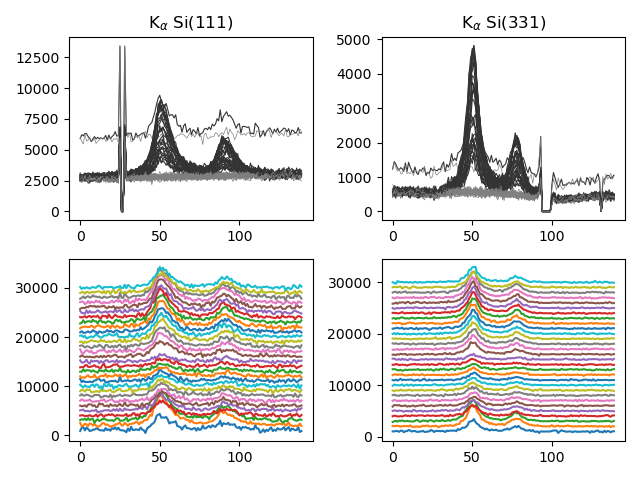

In [3]:
all_Ka_111 = ['FeBpy_Ka111_{:03d}.npy'.format(i+1) for i in range(30)]
all_Ka_331 = ['FeBpy_Ka331_{:03d}.npy'.format(i+1) for i in range(30)]

all_background_111 = ['FeBpy_Ka111_{:03d}_background.npy'.format(i+1) for i in range(30)]
all_background_331 = ['FeBpy_Ka331_{:03d}_background.npy'.format(i+1) for i in range(30)]

DIR = "/sf/alvra/data/p18938/scratch/victoria/spectra_1d/"

scan_numbers = ['{:03d}'.format(i+1) for i in range(30)]

fig = plt.figure(1)
ax11 = fig.add_subplot(2,2,1)
ax11.set_title(r'K$_{\alpha}$ Si(111)')
ax12 = fig.add_subplot(2,2,2)
ax12.set_title(r'K$_{\alpha}$ Si(331)')
ax21 = fig.add_subplot(2,2,3)
ax22 = fig.add_subplot(2,2,4)

for scan_n in scan_numbers:
    
    fileName = "FeBpy_Ka111_{}.npy".format(scan_n)
    background_file = "FeBpy_Ka111_{}_background.npy".format(scan_n)
    
    Ka = np.load(DIR+fileName)
    background = np.load(DIR+background_file)
    
    ax11.plot(Ka, color='0.2', linewidth=0.8, 
#              label=r'S(111) K$_{alpha}$ raw'
            )
    ax11.plot(background, color='0.5', linewidth=0.5)
    ax21.plot(Ka-background + int(scan_n)*1000, 
#              label = 'S(111) K$_{alpha}$ corrected'
            )
    
    fileName = "FeBpy_Ka331_{}.npy".format(scan_n)
    background_file = "FeBpy_Ka331_{}_background.npy".format(scan_n)
    Ka = np.load(DIR+fileName)
    background = np.load(DIR+background_file)
    
    ax12.plot(Ka, color='0.2', linewidth=0.8, 
#              r'S(331) K$_{alpha}$ raw'
            )
    ax12.plot(background, color='0.5', linewidth=0.5)
    ax22.plot(Ka-background + int(scan_n)*1000, 
#              label = 'S(331) K$_{alpha}$ corrected'
            )

# ax11.plot(np.load(DIR+'FeBpy_Ka111_001.npy'), 
#           color='r', linewidth=0.8, 
#             )

plt.tight_layout()    
plt.show()

<IPython.core.display.Javascript object>


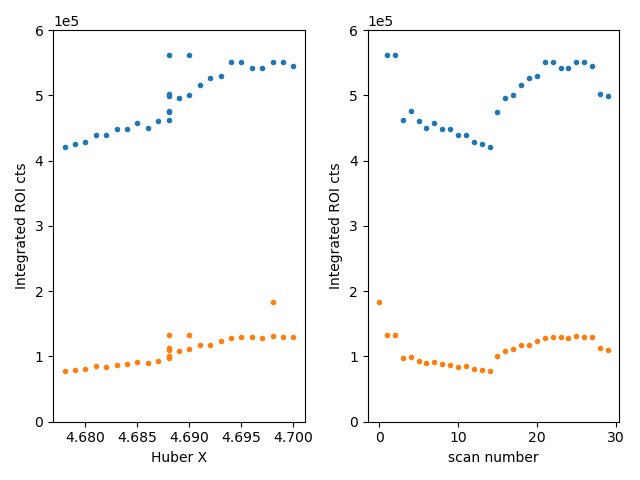

In [11]:
ka_int = np.loadtxt('/sf/alvra/data/p18938/scratch/victoria/total_roi_sum.csv', 
                    dtype=[('Scan', (np.str_, 17)), ('Si(111)', np.float64), 
                           ('Si(331)', np.float64), ('HuberX', np.float64)],
                    delimiter=',', skiprows=1)

data = np.array([list(item) for item in ka_int])
si111 = np.array([float(item) for item in data[:,1]])
si331 = np.array([float(item) for item in data[:,2]])
huber = np.array([float(item) for item in data[:,3]])

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(huber, si111, marker='.', linestyle='none', label='ROI1 Si(111)')
ax1.plot(huber, si331, marker='.', linestyle='none', label='ROI2 Si(331)')
ax1.set_xlabel('Huber X')
ax1.set_ylabel('Integrated ROI cts')
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,1))
ax1.set_ylim(0,6e5)

ax2 = fig.add_subplot(122)
ax2.plot(si111, marker='.', linestyle='none', label='ROI1 Si(111)')
ax2.plot(si331, marker='.', linestyle='none', label='ROI2 Si(331)')
ax2.set_xlabel('scan number')
ax2.set_ylabel('Integrated ROI cts')
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,1))
ax2.set_ylim(0,6e5)

plt.tight_layout()
plt.show()

# New script in the next cell (single file)

In [8]:
DIR

'/sf/alvra/data/p18938/raw/XES_jet_FeBpy_001/'

In [5]:
datalist = glob.glob(DIR + "*.JF02T09V02.h5")
datalist = sorted(datalist)

roi1 = (7740, 7880, 290, 340) # Fe Ka Si(111)
roi2 = (5080, 5220, 210, 250) # Fe Ka Si(311)

# roi1 = (5000, 5200, 220, 290) # Ru ROIs
# roi2 = (4600, 4800, 220, 290)
nshots = None

%mprun -f load_crop_JF_batches_on_off load_crop_JF_batches_on_off(datalist[0], roi1, roi2, 100, 50,\
                                                                  pedestal_file=pedestal_file, nshots=nshots)

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_000870.JF02T09V02.res.h5
jungfrau file: 20:00 07.02.2021
pedestal file: 12:20 07.02.2021
    mtime difference: 7:40:10.360263
Total images = 6000, load them in batches of 1000
Load batch = slice(0, 1000, None)
Load batch = slice(1000, 2000, None)
Load batch = slice(2000, 3000, None)
Load batch = slice(3000, 4000, None)
Load batch = slice(4000, 5000, None)
Load batch = slice(5000, 6000, None)



In [10]:
files = ["run_001730"]
detector = "JF02T09V02"

roi1 = (7740, 7880, 290, 340) # Fe Ka Si(111)
roi2 = (5080, 5220, 210, 250) # Fe Ka Si(311)
#roi1 = (100, 250, 140, 220)
#roi2 = (775, 925, 140, 220)

threshold_low = 5.0
threshold_high = 11

Timezero = 191.945   # position of Timezero on PP delay (in mm!)
######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
Energy_eV_single = 0
Delay_mm_single = 0
        
for f in files:
    JF_single_file = DIR + f + ".{}.h5".format(detector)
    BS_single_file = DIR + f + ".BSDATA.h5"
    print("Processing file %s" % (JF_single_file))
    
#    photon_range = (6, 7)

    nshots = None  # put this to None for ALL images
    #nshots = None
       
    images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
    load_crop_JF_batches_on_off(JF_single_file, roi1, roi2, 100, 50, pedestal_file=pedestal_file, \
                                nshots=nshots)
    
#   images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
#   load_crop_JF_data_on_off(JF_single_file, roi1, roi2, 50, 25, pedestal_file=pedestal_file, \
#                            nshots=nshots)
#     """
    energy, pids = load_single_channel_pulseID(BS_single_file, channel_energy, 100)
    delay, pids = load_single_channel_pulseID(BS_single_file, channel_delay_harm, 100)
#     delay, pids = load_single_channel_pulseID(BS_single_file, channel_delay_global, 100)
    
    energy = [x for x in energy if (x > 0)]
    delay = [x for x in delay if (x > 0)]
    
    Energy_eV_single = np.mean(energy)
    Delay_mm_single = np.mean(delay)
    Delay_ps_single = (Delay_mm_single - Timezero)*2/(3e8*1e3*1e-12) # in ps, change to right t0 !
#     """
#    Izero_pump, Izero_unpump, energy_eV, pulseIDs = \
#    load_FEL_pp_pulseID(BS_single_file, channel_energy, 50, 25, 50)  
    
    images_ON_roi1_thr = images_ON_roi1.copy()
    images_ON_roi1_thr[images_ON_roi1 < threshold_low] = 0
    images_ON_roi1_thr[images_ON_roi1 > threshold_high] = 0
#   images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

    images_ON_roi2_thr = images_ON_roi2.copy()
    images_ON_roi2[images_ON_roi2 < threshold_low] = 0
    images_ON_roi2[images_ON_roi2 > threshold_high] = 0
#   images_ON_roi2 = convert_to_photon_num_range(images_ON_roi2)

    images_OFF_roi1_thr = images_OFF_roi1.copy()
    images_OFF_roi1_thr[images_OFF_roi1 < threshold_low] = 0
    images_OFF_roi1_thr[images_OFF_roi1 > threshold_high] = 0
#   images_OFF_roi1 = convert_to_photon_num_range(images_OFF_roi1)

    images_OFF_roi2_thr = images_OFF_roi2.copy()
    images_OFF_roi2[images_OFF_roi2 < threshold_low] = 0
    images_OFF_roi2[images_OFF_roi2 > threshold_high] = 0
#   images_OFF_roi2 = convert_to_photon_num_range(images_OFF_roi2)

    spectrum_ON_roi1  = images_ON_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_OFF_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2  = images_ON_roi2.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_OFF_roi2.sum(axis = 1).sum(axis = 0)
    
print ("Job done! It took {} seconds to process {} file".format(round((time.time() - start_time), 2),len(files)))

Processing file /sf/alvra/data/p18938/raw/XES_jet_FeBpy_001/run_001730.JF02T09V02.h5
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_000870.JF02T09V02.res.h5
jungfrau file: 20:00 07.02.2021
pedestal file: 12:20 07.02.2021
    mtime difference: 7:40:10.360263
Total images = 6000, load them in batches of 1000
Load batch = slice(0, 1000, None)
Load batch = slice(1000, 2000, None)
Load batch = slice(2000, 3000, None)
Load batch = slice(3000, 4000, None)
Load batch = slice(4000, 5000, None)
Load batch = slice(5000, 6000, None)


/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Job done! It took 27.99 seconds to process 1 file


In [13]:
Delay_ps_single

1.0333399244800983

<IPython.core.display.Javascript object>


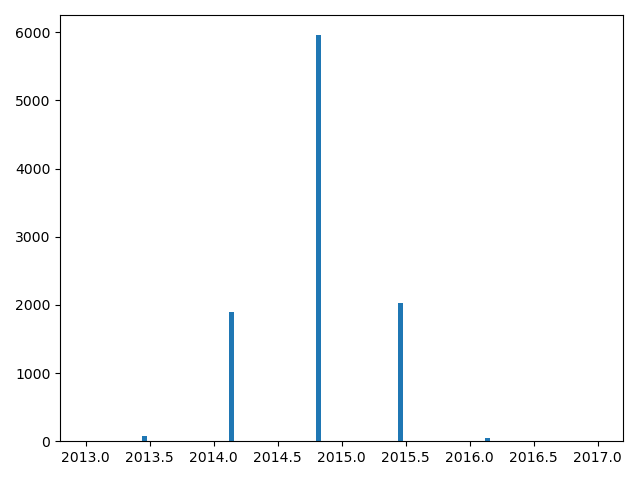

In [27]:
# test_file = h5py.File(BS_single_file, "r")
# BS_single_file
# print (test_file)
# print(list(test_file.keys()))
# print('\n')
# print(list(test_file['SLAAR11-LTIM01-EVR0:CALCI']))
# print(list(test_file['SLAAR11-LTIM01-EVR0:CALCS']))
# print(list(test_file['SLAAR11-LTIM01-EVR0:CALCX']))
# print(list(test_file['SLAAR11-LTIM01-EVR0:CALCY']))

# energy, pids = load_single_channel_pulseID(BS_single_file, channel_energy, 100)
# print(energy)
# print(sum(energy>0))

# delay, pids = load_single_channel_pulseID(BS_single_file, channel_delay_global, 100)
# print(delay)

plt.figure()
plt.hist(delay, bins=100, range=(2013.0,2017.0))
plt.tight_layout()
plt.show()


## Plot spectra of both ROIs together

<IPython.core.display.Javascript object>


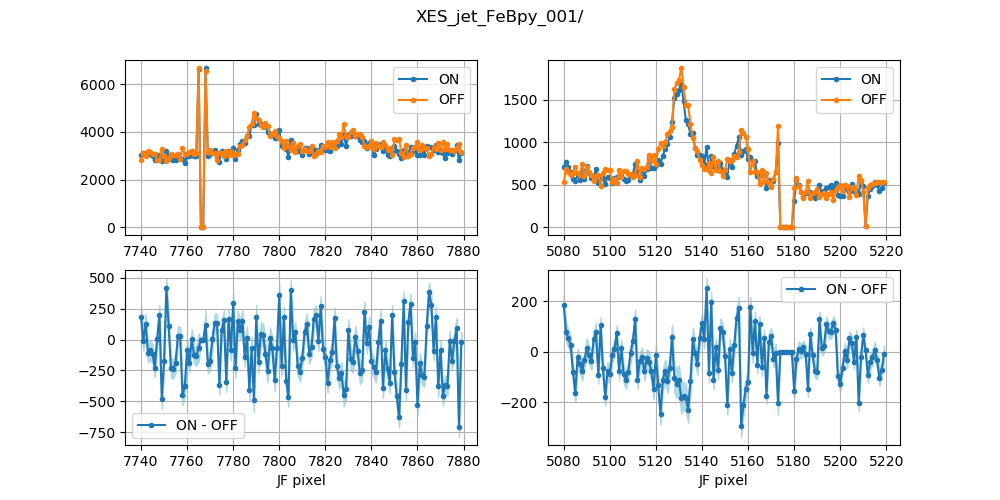

In [12]:
from textwrap import wrap
bin1_ = 1  # change the bin size if wanted, 1 is every pixel
bin2_ = 1  # change the bin size if wanted, 1 is every pixel

spectra_on1 = spectrum_ON_roi1.copy()
spectra_off1 = spectrum_OFF_roi1.copy()
spectra_on2 = spectrum_ON_roi2.copy()
spectra_off2 = spectrum_OFF_roi2.copy()

x_axis1 = np.arange(roi1[0], roi1[1])
x_axis2 = np.arange(roi2[0], roi2[1])

spectra_on_rebin1  = bin_sum(spectra_on1,  bin1_)
spectra_off_rebin1 = bin_sum(spectra_off1, bin1_)
x_axis_rebin1 = bin_mean(x_axis1, bin1_)
spectra_on_rebin2  = bin_sum(spectra_on2,  bin2_)
spectra_off_rebin2 = bin_sum(spectra_off2, bin2_)
x_axis_rebin2 = bin_mean(x_axis2, bin2_)

spectra_on_err1  = np.sqrt(spectra_on_rebin1)
spectra_off_err1 = np.sqrt(spectra_off_rebin1)
spectra_on_err2  = np.sqrt(spectra_on_rebin2)
spectra_off_err2 = np.sqrt(spectra_off_rebin2)

low_err1= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err1= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
low_err2= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err2= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)

plt.figure(figsize=(10,5))
plt.suptitle(scan_name)

plt.subplot(221)

# plt.gca().set_title("\n".join(wrap('ROI1: {} Energy = {} eV'.format(roi1, np.round(Energy_eV_single, 2)),30)))
#plt.gca().set_title('ROI1: [], Delay = {} ps'.format(roi1, np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(223)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin1, low_err1, high_err1, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.subplot(222)
# plt.gca().set_title("\n".join(wrap('ROI2: {} Energy = {} eV'.format(roi2, np.round(Energy_eV_single, 2)),30)))
#plt.gca().set_title('ROI2: [], Delay = {} ps'.format(roi2, np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin2, spectra_on_rebin2, label="ON", marker='.')
plt.plot(x_axis_rebin2, spectra_off_rebin2, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(224)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin2, low_err2, high_err2, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.show()

## Or separately: ROI1

In [ ]:
bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[0], roi1[1])

spectra_on_rebin1  = bin_sum(spectra_on,  bin_)
spectra_off_rebin1 = bin_sum(spectra_off, bin_)
x_axis_rebin1 = bin_mean(x_axis, bin_)

spectra_on_err1  = np.sqrt(spectra_on_rebin1)
spectra_off_err1 = np.sqrt(spectra_off_rebin1)



#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.suptitle(scan_name + ' // ROI1: {}'.format(roi1))
plt.subplot(211)
# plt.gca().set_title('Energy = {} eV'.format(np.round(Energy_eV_single, 2)))
#plt.gca().set_title('Delay = {} ps'.format(np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
#plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.xlabel("JF pixel")
plt.grid()


plt.legend(loc="best")
plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

## Or separately: ROI2

In [ ]:
bin_ = 1  # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi2.copy()
spectra_off = spectrum_OFF_roi2.copy()

x_axis = np.arange(roi2[0], roi2[1])

spectra_on_rebin2  = bin_sum(spectra_on,  bin_)
spectra_off_rebin2 = bin_sum(spectra_off, bin_)
x_axis_rebin2 = bin_mean(x_axis, bin_)

spectra_on_err2  = np.sqrt(spectra_on_rebin2)
spectra_off_err2 = np.sqrt(spectra_off_rebin2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.suptitle(scan_name + ' // ROI1: {}'.format(roi1))
plt.subplot(211)
# plt.gca().set_title('Energy = {} eV'.format(np.round(Energy_eV_single, 2)))
#plt.gca().set_title('Delay = {} ps'.format(np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin2, spectra_on_rebin2, label="ON", marker='.')
plt.plot(x_axis_rebin2, spectra_off_rebin2, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)

low_err= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
plt.xlabel("JF pixel")
plt.grid()

#plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
plt.fill_between(x_axis_rebin2, low_err, high_err, color='lightblue')
plt.show()

# New script in the next cell (scans) 

In [ ]:
print (DIR_json + scan_name + scan_range + ".json")

In [ ]:
scan_name = "RuBpy_RIXS_1"          # you need to change this name, but run also cell #3 above to get scan_range
detector = "JF02T09V02"

roi1 = (5000, 5200, 220, 290)
roi2 = (4600, 4800, 220, 290) #Ru ROIs
#roi1 = (6450, 6550, 220, 300)
#roi2 = (5450, 5700, 220, 300)
threshold_low = 2.0
threshold_high = 10

######################################################################################

fname_scan = DIR_json + scan_name + scan_range + ".json"
scan_data = load_scan_data(fname_scan)


Energy_eV = []
Delay_mm = []
XAS_roi1 = []
XAS_roi1_on = []
#Error_XAS_roi1 = []
XAS_roi2 = []
XAS_roi2_on = []
#Error_XAS_roi2 = []
RIXS_transient_roi1 = []
RIXS_transient_roi2 = []
Error_transient_roi1 = []
Error_transient_roi2 = []
RIXS_unpumped_roi1 = []
RIXS_unpumped_roi2 = []
Error_unpumped_roi1 = []
Error_unpumped_roi2 = []
RIXS_pumped_roi1 = []
RIXS_pumped_roi2 = []
Error_pumped_roi1 = []
Error_pumped_roi2 = []
XAS_transient_roi1=[]
XES_transient_roi1 =[]
XAS_transient_roi2=[]
XES_transient_roi2 =[]

#XES_1D = []

clock = Clock()
num_scan_files = len(scan_data)
print("\nProcessing", num_scan_files, "total files")

for i, (bs, fn) in enumerate(scan_data):
#for i in range(0,4):
    print("\n File {} out of {}: Processing {}".format(i+1, num_scan_files, fn.split('/')[-2:]))
    
    spectrum_ON_roi1 = 0
    spectrum_OFF_roi1 = 0
    spectrum_ON_roi2 = 0
    spectrum_OFF_roi2 = 0
    
    nshots = None  # put this to None for ALL images
    #nshots = None
    
    
    images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
    load_crop_JF_batches_on_off(fn, roi1, roi2, 50, 25, pedestal_file=pedestal_file, nshots=nshots)
    
#   images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
#   load_crop_JF_data_on_off(fn, roi1, roi2, 50, 25, pedestal_file=pedestal_file, nshots=nshots)
    
    energy, pids = load_single_channel_pulseID(bs, channel_energy, 50)
    energy = [x for x in energy if (x > 0)]
    Energy_eV.append(np.mean(energy))
    
    delay, pids = load_single_channel_pulseID(bs, channel_delay, 50)
    delay = [x for x in delay if (x > 0)]
    Delay_mm.append(np.mean(delay))
    
    images_ON_roi1_thr = images_ON_roi1.copy()
    images_ON_roi1_thr[images_ON_roi1 < threshold_low] = 0
    images_ON_roi1_thr[images_ON_roi1 > threshold_high] = 0
    
    images_OFF_roi1_thr = images_OFF_roi1.copy()
    images_OFF_roi1_thr[images_OFF_roi1 < threshold_low] = 0
    images_OFF_roi1_thr[images_OFF_roi1 > threshold_high] = 0
    
    images_ON_roi2_thr = images_ON_roi2.copy()
    images_ON_roi2_thr[images_ON_roi2 < threshold_low] = 0
    images_ON_roi2_thr[images_ON_roi2 > threshold_high] = 0
    
    images_OFF_roi2_thr = images_OFF_roi2.copy()
    images_OFF_roi2_thr[images_OFF_roi2 < threshold_low] = 0
    images_OFF_roi2_thr[images_OFF_roi2 > threshold_high] = 0
    
    spectrum_ON_roi1 = images_ON_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_OFF_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2 = images_ON_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_OFF_roi2_thr.sum(axis = 1).sum(axis = 0)

######################### ROI 1 ##############################################
    
    XAS_roi1.append(np.abs(spectrum_OFF_roi1.sum()))
    XAS_roi1_on.append(np.abs(spectrum_ON_roi1.sum()))
    RIXS_unpumped_roi1.append(spectrum_OFF_roi1)
    Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
    RIXS_pumped_roi1.append(spectrum_ON_roi1)
    Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))
    RIXS_transient_roi1.append(spectrum_ON_roi1 - spectrum_OFF_roi1)
    Error_transient_roi1.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
    
    XES_transient_roi1.append(np.abs(spectrum_ON_roi1 - spectrum_OFF_roi1))
 #   XES_1D.append(np.sum(XES_transient_roi1, axis = 1))
    
    XAS_transient_roi1.append(np.abs(np.sum(RIXS_transient_roi1)))
    
######################### ROI 2 ##############################################
    
    XAS_roi2.append(np.abs(spectrum_OFF_roi2.sum()))
    XAS_roi2_on.append(np.abs(spectrum_ON_roi2.sum()))
    RIXS_unpumped_roi2.append(spectrum_OFF_roi2)
    Error_unpumped_roi2.append(np.sqrt(spectrum_OFF_roi2))
    RIXS_pumped_roi2.append(spectrum_ON_roi2)
    Error_pumped_roi2.append(np.sqrt(spectrum_ON_roi2))
    RIXS_transient_roi2.append(spectrum_ON_roi2 - spectrum_OFF_roi2)
    Error_transient_roi2.append(np.sqrt((np.sqrt(spectrum_ON_roi2))**2 + (np.sqrt(spectrum_OFF_roi2))**2))
    
    XES_transient_roi2.append(np.abs(spectrum_ON_roi2 - spectrum_OFF_roi2))
#    XES_1D.append(np.sum(XES_transient_roi2, axis = 1))
    
    XAS_transient_roi2.append(np.abs(np.sum(RIXS_transient_roi2)))
    clear_output(wait=True)
    
    print ("It took {} to process file {}".format(clock.tick(), fn.split('/')[-1]))

Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)
XAS_roi1 = np.array(XAS_roi1)
XAS_roi1_on = np.array(XAS_roi1_on)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)
XAS_transient_roi1=np.array(XAS_transient_roi1)
XES_transient_roi1=np.array(XES_transient_roi1)
#XES_1D=np.array(XES_1D)
XAS_roi2 = np.array(XAS_roi2)
XAS_roi2_on = np.array(XAS_roi2_on)
RIXS_unpumped_roi2 = np.array(RIXS_unpumped_roi2)
Error_unpumped_roi2 = np.array(Error_unpumped_roi2)
RIXS_pumped_roi2 = np.array(RIXS_pumped_roi2)
Error_pumped_roi2 = np.array(Error_pumped_roi2)
RIXS_transient_roi2 = np.array(RIXS_transient_roi2)
Error_transient_roi2 = np.array(Error_transient_roi2)
XAS_transient_roi2=np.array(XAS_transient_roi2)
XES_transient_roi2=np.array(XES_transient_roi2)
#XES_1D=np.array(XES_1D)

print ("\nJob done! It took", clock.tock(), "seconds to process", num_scan_files, "file(s)")



In [ ]:
outdir = '/das/work/p18/p18442/Exported_data/'
filename_h5 = outdir + scan_name + "_export.h5" 
with h5py.File(filename_h5, "w") as file2write:
    file2write.create_dataset("energy_eV", data = Energy_eV)
    file2write.create_dataset("roi1", data = roi1)
    file2write.create_dataset("pump_roi1", data = RIXS_pumped_roi1)
    file2write.create_dataset("unpump_roi1", data = RIXS_unpumped_roi1)
    file2write.create_dataset("transient_roi1", data = RIXS_transient_roi1)
    file2write.create_dataset("roi2", data = roi2)
    file2write.create_dataset("pump_roi2", data = RIXS_pumped_roi2)
    file2write.create_dataset("unpump_roi2", data = RIXS_unpumped_roi2)
    file2write.create_dataset("transient_roi2", data = RIXS_transient_roi2)

print(filename_h5)

In [ ]:
scan_name_load = 'RuBpy_RIXS_6'

##########################################################

outdir = '/das/work/p18/p18442/Exported_data/'
fn = outdir + scan_name_load + "_export.h5" 
print (fn)
with h5py.File(fn, "r") as file2open:
    Energy_eV = file2open['energy_eV'][:]
    roi1 = file2open['roi1'][:]
    RIXS_pumped_roi1 = file2open['pump_roi1'][:]
    RIXS_unpumped_roi1 = file2open['unpump_roi1'][:]
    RIXS_transient_roi1 = file2open['transient_roi1'][:]
    roi2 = file2open['roi2'][:]
    RIXS_pumped_roi2 = file2open['pump_roi2'][:]
    RIXS_unpumped_roi2 = file2open['unpump_roi2'][:]
    RIXS_transient_roi2 = file2open['transient_roi2'][:]

### For no pump probe data:

In [ ]:
RIXS_total = RIXS_unpumped_roi1 + RIXS_pumped_roi1

plt.figure(figsize=(8,4))
plt.imshow(RIXS_total, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")

plt.title(scan_name_load)
plt.colorbar()
plt.show()


### For pump probe data (ROI1 and ROI2 together):

In [ ]:
plt.figure(figsize=(10,8))
plt.suptitle(scan_name_load)
plt.subplots_adjust(hspace=0.5)

plt.subplot(321)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS unpumped roi1")
plt.colorbar()

plt.subplot(322)
plt.imshow(RIXS_unpumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS unpumped roi2")
plt.colorbar()

plt.subplot(323)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS pumped roi1")
plt.colorbar()

plt.subplot(324)
plt.imshow(RIXS_pumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS pumped roi2")
plt.colorbar()

plt.subplot(325)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi1")
plt.colorbar()

plt.subplot(326)
plt.imshow(RIXS_transient_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi2")
plt.colorbar()



plt.show()

### Only ROI1

In [ ]:
plt.figure(figsize=(5,9))
plt.suptitle(scan_name_load)
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS unpumped roi1")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS pumped roi1")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi1")
plt.colorbar()
plt.show()

### Only ROI2

In [ ]:
plt.figure(figsize=(5,9))
plt.suptitle(scan_name_load)
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS unpumped roi2")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS pumped roi2")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi2")
plt.colorbar()
plt.show()

## XAS plots in PFY

### ROI1

In [ ]:
XAS_pump_roi1 =  np.sum(RIXS_pumped_roi1, axis=1)
XAS_unpump_roi1 = np.sum(RIXS_unpumped_roi1, axis=1)
XAS_pumpprobe_roi1 = XAS_pump_roi1 - XAS_unpump_roi1

plt.figure(figsize=(10,5))
plt.suptitle(scan_name_load + '    XAS, roi1')
plt.subplot(121)
plt.plot(Energy_eV,XAS_pump_roi1, label="laser on", marker='.')
plt.plot(Energy_eV,XAS_unpump_roi1, label="laser off", marker='.')
plt.legend(loc='best')
plt.xlabel("Incident energy (eV)")
plt.grid()
plt.ylabel("Counts")

plt.subplot(122)
plt.plot(Energy_eV,XAS_pumpprobe_roi1, label="pump probe",color='green', marker='.')
plt.legend(loc='best')
plt.xlabel("Incident energy (eV)")
plt.grid()
plt.show()

### ROI2

In [ ]:
XAS_pump_roi2 =  np.sum(RIXS_pumped_roi2, axis=1)
XAS_unpump_roi2 = np.sum(RIXS_unpumped_roi2, axis=1)
XAS_pumpprobe_roi2 = XAS_pump_roi2 - XAS_unpump_roi2

plt.figure(figsize=(10,5))
plt.suptitle(scan_name_load + '    XAS, roi2')
plt.subplot(121)
plt.plot(Energy_eV,XAS_pump_roi2, label="laser on", marker='.')
plt.plot(Energy_eV,XAS_unpump_roi2, label="laser off", marker='.')
plt.legend(loc='best')
plt.xlabel("Incident energy (eV)")
plt.grid()
plt.ylabel("Counts")

plt.subplot(122)
plt.plot(Energy_eV,XAS_pumpprobe_roi2, label="pump probe",color='green', marker='.')
plt.legend(loc='best')
plt.xlabel("Incident energy (eV)")
plt.grid()
plt.show()

In [ ]:
Timezero = 194.6   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

plt.figure(figsize=(8,4))
plt.plot(Delay_ps, XES_transient_roi1.sum(axis = 1), marker ='.')
plt.xlabel("delay (ps)")
plt.ylabel("Incident energy (eV)")

plt.title(scan_name)
plt.show()


In [ ]:
Timezero = 194.6   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

plt.figure()
#plt.plot(Energy_eV,RIXS_transient_roi1, label="", marker='.')
plt.plot(Delay_ps,XES_1D, label="", marker='.')
plt.xlabel("Delay (ps)")
plt.ylabel("Counts")
plt.show

In [ ]:
plt.figure(figsize=(5,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Delay_ps[0], Delay_ps[-1]])
plt.title("RIXS unpumped")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Delay_ps[0], Delay_ps[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS pumped")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "rainbow", origin ="lower", extent=[roi1[0], roi1[1], Delay_ps[0], Delay_ps[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS transient")
plt.colorbar()
plt.show()

In [ ]:
np.sum(np.abs(RIXS_transient_roi1))

In [ ]:
plt.figure()
#plt.plot(Energy_eV,RIXS_transient_roi1, label="", marker='.')
plt.plot(Energy_eV,XAS_roi1_on-XAS_roi1, label="", marker='.')
plt.xlabel("Incident energy (eV)")
plt.ylabel("Counts")
plt.show

plt.figure()
plt.plot(x_axis,RIXS_transient_roi1.sum(axis=0), label="", marker='.')
plt.xlabel("Pixels")
plt.ylabel("Counts")
plt.show

plt.figure()
plt.plot(Delay_ps,np.abs(RIXS_transient_roi1).sum(axis=1), label="", marker='.')
plt.xlabel("Delay ps")
plt.ylabel("Counts")
plt.show

In [ ]:
Timezero = 194.6   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

plt.figure()
#plt.plot(Energy_eV,RIXS_transient_roi1, label="", marker='.')
plt.plot(Delay_ps,XAS_roi1_on-XAS_roi1, label="", marker='.')
plt.xlabel("Delay (ps)")
plt.ylabel("Counts")
plt.show

In [ ]:
plt.figure(figsize=(5,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Delay_mm[0], Energy_eV[-1]])
plt.title("RIXS unpumped")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Delay_mm[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS pumped")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "rainbow", origin ="lower", extent=[roi1[0], roi1[1], Delay_mm[0], Energy_eV[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS transient")
plt.colorbar()
plt.show()

In [ ]:
savedir = '/das/work/p18/p18387/exported_data/'
filename_txt = savedir + "run001710_Ka.txt" 
output_matrix =[]
output_matrix = np.array(x_axis)
output_matrix = np.vstack((output_matrix, np.array(spectrum_ON_roi1)))
output_matrix = np.vstack((output_matrix, np.array(spectrum_OFF_roi1)))
#output_matrix = np.array()
#output_matrix = np.vstack((output_matrix, np.array(spectrum_ON_roi2)))
#output_matrix = np.vstack((output_matrix, np.array(spectrum_OFF_roi2)))

np.savetxt(filename_txt, np.transpose(output_matrix))

In [ ]:
def edge_removal(module_edge, roi_removal, array):
    index_edge = module_edge - roi_removal[0]
    array_input = array.copy()
    print (array[index_edge-1:index_edge+3])
    array[index_edge] = array[index_edge-1]/2
    array[index_edge-1] = array[index_edge-1]/2

    array[index_edge+1] = array[index_edge+2]/2
    array[index_edge+2] = array[index_edge+2]/2 
    print (array[index_edge-1:index_edge+3])
    return array, array_input

In [ ]:
spectrum_ON_roi1, spectrum_ON_roi1_orig = edge_removal(6472, roi1, spectrum_ON_roi1) 
spectrum_OFF_roi1, spectrum_OFF_roi1_orig = edge_removal(6472, roi1, spectrum_OFF_roi1) 